In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import fastai
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *

In [3]:
csv_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
df = pd.read_csv(csv_path)
df.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization
4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest
...,...,...,...,...,...,...,...
1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity
1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity
121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk
7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk


In [4]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease",
    "bcc" : "basal cell carcinoma" , 
    "bkl" : "benign keratosis-like lesions", 
    "df" : "dermatofibroma", 
    "mel" : "melanoma", 
    "nv" : "melanocytic nevi", 
    "vasc" : "vascular lesions", 
}

In [5]:
img_to_class_dict = df.loc[:, ["image_id", "dx"]]
img_to_class_dict = img_to_class_dict.to_dict('list')  
img_to_class_dict = {img_id : short_to_full_name_dict[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['dx']) } 
[x for x in img_to_class_dict.items()][:5]

[('ISIC_0027419', 'benign keratosis-like lesions'),
 ('ISIC_0025030', 'benign keratosis-like lesions'),
 ('ISIC_0026769', 'benign keratosis-like lesions'),
 ('ISIC_0025661', 'benign keratosis-like lesions'),
 ('ISIC_0031633', 'benign keratosis-like lesions')]

In [6]:
def get_label_from_dict(path):
    return img_to_class_dict[path.stem]

skin_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    item_tfms=[Resize(450), DihedralItem()], 
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42), 
    get_y=get_label_from_dict, 
)

img_path = "/kaggle/input/skin-cancer-mnist-ham10000"
dls = skin_db.dataloaders(img_path)

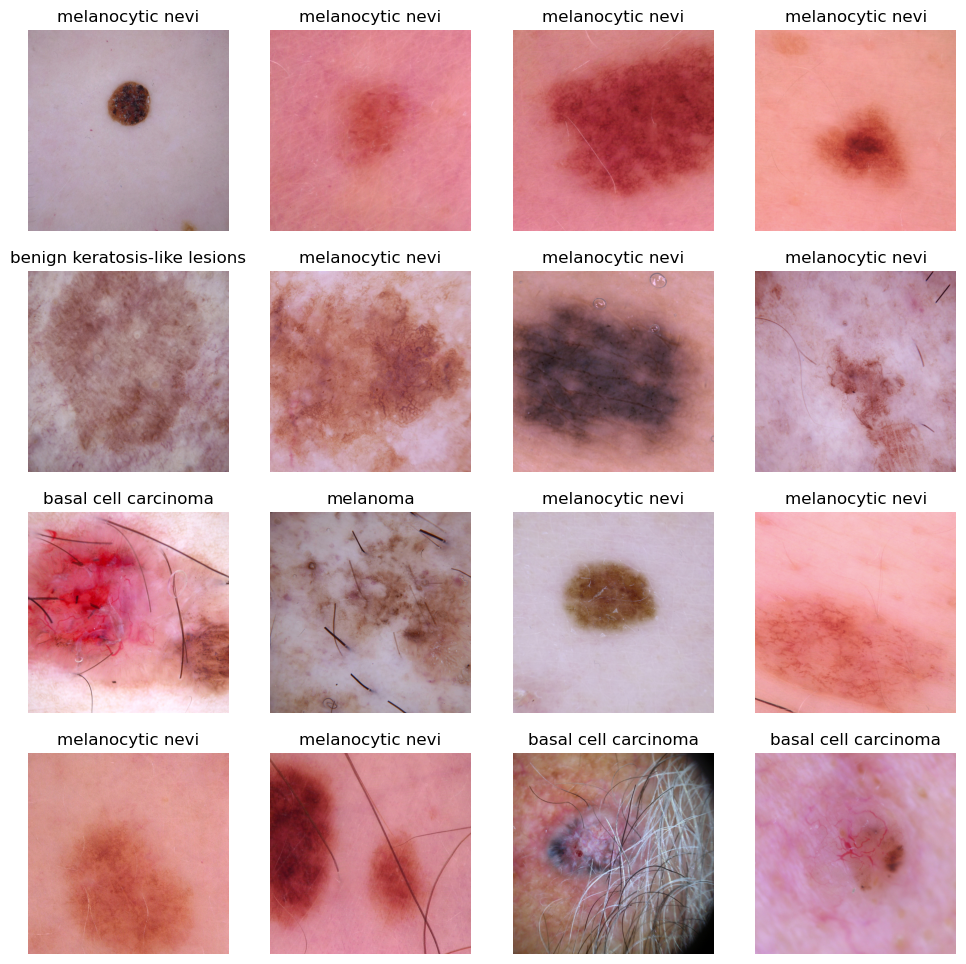

In [7]:
dls.show_batch(max_n=16, nrows=4)

In [8]:
!pip install GPUtil

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=db8521e9cb6391b5a44835bc55911fe3da4f8e1f8d7e1c7d85c4157b7ba1ecd4
  Stored in directory: /root/.cache/pip/wheels/b1/e7/99/2b32600270cf23194c9860f029d3d5db075f250bc39028c045
Successfully built GPUtil


In [9]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

import torch
torch.cuda.empty_cache()

| ID | GPU | MEM |
------------------
|  0 |  0% |  9% |


In [10]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, opt_func=ranger)
learn.fine_tune(epochs=30, freeze_epochs=3, base_lr=0.005, cbs=MixUp(0.5))

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/model

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.043256,1.086300,0.691130,06:50
1,1.104947,0.624305,0.775503,04:13
2,0.885769,0.573451,0.796472,04:13


epoch,train_loss,valid_loss,accuracy,time
0,0.755308,0.468768,0.834249,04:26
1,0.707593,0.411693,0.858712,04:27
2,0.672564,0.375797,0.870528,04:27
3,0.650821,0.344235,0.889665,04:28
4,0.634279,0.345014,0.883342,05:43
5,0.601421,0.321498,0.891829,05:38
6,0.596203,0.397159,0.857880,04:40
7,0.585376,0.269682,0.914961,06:47
8,0.571816,0.366504,0.875021,06:23
9,0.552480,0.259081,0.913796,04:51
